# Analisi esplorativa dei dati {#sec-freq-distribution}

**Prerequisiti**

- Leggi l'@sec-sums prima di procedere con la lettura di questo capitolo per una comprensione completa delle operazioni descritte.
- Leggi [*Testing Statistical Charts: What Makes a Good Graph?* (Vanderplas, Cook, and Hofmann 2020)](https://doi.org/10.1146/annurev-statistics-031219-041252). Questo articolo descrive le migliori pratiche per la creazione di grafici.
- Consulta il capitolo [Data visualization](https://r4ds.hadley.nz/data-visualize) di @wickham2023r. Questo capitolo fornisce una panoramica degli aspetti fondamentali della visualizzazione dei dati.
- Consulta [Data Visualization. A practical introduction](https://socviz.co) di @healy2018data.
- Consulta [Fundamentals of Data Visualization](https://clauswilke.com/dataviz/) di @wilke2019fundamentals.
- Consulta il capitolo [Data visualization](https://r4ds.hadley.nz/data-visualize.html) di *R for Data Science* [@wickham2023r].

**Concetti e competenze chiave**

- L'analisi esplorativa dei dati (Exploratory Data Analysis, EDA) è il processo di familiarizzazione con un nuovo dataset attraverso l'esame dei dati, la costruzione di grafici, tabelle e modelli. 
- Un aspetto fondamentale della EDA riguarda la descrizione della distribuzione di ciascuna variabile presa singolarmente. La distribuzione di una variabile viene rappresentata attraverso una distribuzione di frequenze. 

**Preparazione del Notebook**

In [11]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az
from pathlib import Path

In [12]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Introduzione

Un aspetto cruciale del lavoro di un data scientist è la capacità di presentare in modo chiaro ed efficace le intuizioni derivanti dall'analisi dei dati. Questo è fondamentale sia per la comprensione personale sia per la comunicazione con altri, in particolare con coloro che potrebbero utilizzare tali informazioni per prendere decisioni concrete nel mondo reale.

La comunicazione efficace dei dati e dei risultati derivati raramente avviene attraverso la semplice presentazione dei dati grezzi o degli output di codice. Questi formati non permettono di rilevare facilmente pattern significativi. Invece, i dati e i risultati vengono generalmente presentati in due modi principali:

- **Sintesi statistiche:** Utilizzando medie o altri valori rappresentativi, spesso organizzati in tabelle concise.
- **Rappresentazioni visive:** Attraverso grafici, dove elementi come forme, distanze, colori e dimensioni illustrano le grandezze e le relazioni tra i valori contenuti nei dati.

In questo capitolo, esploreremo le strategie per sintetizzare grandi volumi di dati, concentrandoci su concetti chiave come le distribuzioni di frequenza, i quantili e le tecniche di visualizzazione. Esamineremo sia gli aspetti computazionali sia quelli interpretativi di queste misure, fornendo gli strumenti necessari per rappresentare graficamente le sintesi dei dati in modo efficace.

In particolare, ci focalizzeremo sull'uso della visualizzazione dei dati per condurre l'analisi esplorativa dei dati (EDA). L'EDA consiste nel riassumere visivamente e numericamente i pattern, le tendenze e le relazioni presenti in un dataset, nel contesto del problema di dominio che stiamo cercando di risolvere. L'obiettivo delle esplorazioni EDA è comprendere le tendenze e i pattern che risponderanno alla domanda che motiva l'analisi dei dati. In questo capitolo esamineremo tre metodi per rappresentare graficamente una distribuzione di frequenze:

- l'istogramma,
- l'istogramma lisciato,
- il box-plot.


## I dati sulle aspettative negative nella depressione

Per illustrare i principali strumenti dell'EDA, analizzeremo i dati sulle aspettative negative come meccanismo chiave nel mantenimento della depressione [@zetsche_2019future]. Come abbiamo visto nel camìpitolo precedente, avendo definito `project_directory` come root

In [4]:
# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory
project_directory = os.path.join(home_directory, "_repositories", "psicometria")

è possibile specificare il percorso del file CSV che contiene i dati in relazione a `project_directory`:

In [5]:
file_path = os.path.join(project_directory, "data", "data.mood.csv")

Leggiamo i dati grezzi del file `data.mood.csv` in un DataFrame pandas:

In [6]:
df = pd.read_csv(file_path)

Per questo esercizio, ci concentriamo sulle colonne `esm_id` (il codice del soggetto), `group` (il gruppo) e `bdi` (il valore BDI-II).

In [7]:
df = df[["esm_id", "group", "bdi"]]
df.head()

,esm_id,group,bdi
0,10,mdd,25.0
1,10,mdd,25.0
2,10,mdd,25.0
3,10,mdd,25.0
4,10,mdd,25.0


Una delle prime cose da fare, quando esaminiamo un dataset, è capire che tipo di variabili sono incluse.

In [8]:
df.dtypes

esm_id      int64
group      object
bdi       float64
dtype: object

Nel caso specifico, notiamo che la variabile `group` è di tipo `object`, quindi è una variabile qualitativa, mentre le altre variabili sono numeriche, rappresentate come numeri interi (`int64`) o a virgola mobile (`bdi`). 

Se elenchiamo le modalità presenti in `group` utilizzando il metodo `unique()`, scopriamo che corrispondono a `mdd` (pazienti) e `ctl` (controlli sani).

In [9]:
df["group"].unique()

array(['mdd', 'ctl'], dtype=object)

Rimuoviamo i duplicati per ottenere un unico valore BDI-II per ogni soggetto:

In [5]:
df = df.drop_duplicates(keep="first")

Verifichiamo di avere ottenuto il risultato desiderato.

In [6]:
df.shape

(67, 3)

In [10]:
df.head()

,esm_id,group,bdi
0,10,mdd,25.0
14,9,mdd,30.0
29,6,mdd,26.0
45,7,mdd,35.0
64,12,mdd,44.0


Si noti che il nuovo DataFrame (con 67 righe) conserva il "nome" delle righe (ovvero, l'indice di riga) del DataFrame originario (con 1188 righe). Per esempio, il secondo soggetto (con codice identificativo 9) si trova sulla seconda riga del DataFrame, ma il suo indice di riga è 15. Questo non ha nessuna conseguenza perché non useremo l'indice di riga nelle analisi seguenti.

Eliminiamo eventuali valori mancanti:

In [7]:
df = df[pd.notnull(df["bdi"])]

Otteniamo così il DataFrame finale per gli scopi presenti (66 righe e 3 colonne):

In [7]:
df.shape

(66, 3)

Stampiamo i valori BDI-II presentandoli ordinati dal più piccolo al più grande:

In [8]:
print(df["bdi"].sort_values())

682     0.0
455     0.0
465     0.0
485     0.0
540     0.0
       ... 
190    39.0
810    41.0
150    43.0
135    43.0
64     44.0
Name: bdi, Length: 66, dtype: float64


Nella terminologia statistica, l'osservazione è l'informazione raccolta da un individuo o un'entità specifica che partecipa allo studio. Considerando il dataset di @zetsche_2019future, l'unità di osservazione è costituita dai partecipanti allo studio. Pertanto, nel DataFrame denominato `df`, ogni riga simboleggia un individuo distinto coinvolto nell'indagine.

Le variabili, d'altro canto, sono espressioni delle diverse caratteristiche degli individui o delle entità analizzate. Nel contesto del progetto STAR, questo concetto si traduce in:

- Ogni colonna di `df` rappresenta una variabile che incarna una particolare proprietà condivisa dai partecipanti.
- Le variabili sono identificate attraverso etichette collegate alle colonne, come `esa_id` (il codice identificativo dei soggetti), `mdd` (il gruppo di appartenza), e `bdi` (il valore del test BDI-II).

Per rappresentare un'osservazione singola della variabile generica $X$, si utilizza la notazione $X_i$, dove $i$ rappresenta l'indice dell'osservazione. Questo indice significa che abbiamo un valore differente di $X$ per ogni valore distinto di $i$. Ad esempio, nel caso di 67 osservazioni, $i$ può variare da 1 a 67. Pertanto, per simboleggiare la seconda osservazione (quella con $i=2$), useremo la notazione $X_2$. È fondamentale tener presente che, mentre in Python gli indici iniziano da 0, nella notazione matematica tradizionale, come quella rappresentata da $X_i$, l'indice ha inizio da 1. 

## Distribuzioni di frequenze

È chiaro dall'output esaminato nella sezione precedente che i dati grezzi non sono molto informativi. Ci porremo ora l'obiettivo di creare una rappresentazione sintetica e comprensibile di questi dati.

Una distribuzione di frequenze rappresenta il conteggio delle volte in cui i valori di una variabile si verificano all’interno di un intervallo. Per i nostri dati BDI-II, categorizziamo i punteggi in quattro classi:

- 0–13: depressione minima
- 14–19: depressione lieve-moderata
- 20–28: depressione moderata-severa
- 29–63: depressione severa

Ogni classe $\Delta_i$ rappresenta un intervallo di valori aperto a destra $[a_i, b_i)$ o aperto a sinistra $(a_i, b_i]$. Ad ogni classe $\Delta_i$, con limiti inferiori e superiori $a_i$ e $b_i$, vengono associati un'ampiezza $b_i - a_i$ (che non è necessariamente uguale per ogni classe) e un valore centrale $\bar{x}_i$. Poiché ogni osservazione $x_i$ appartiene a una sola classe $\Delta_i$, è possibile calcolare le seguenti quantità.

-   La *frequenza assoluta* $n_i$ di ciascuna classe, ovvero il numero di osservazioni che ricadono nella classe $\Delta_i$.
    -   Proprietà: $n_1 + n_2 + \dots + n_m = n$.
-   La *frequenza relativa* $f_i = n_i/n$ di ciascuna classe.
    -   Proprietà: $f_1+f_2+\dots+f_m =1$.
-   La *frequenza cumulata* $N_i$, ovvero il numero totale delle osservazioni che ricadono nelle classi fino alla $i$-esima compresa: $N_i = \sum_{i=1}^m n_i.$
-   La *frequenza cumulata relativa* $F_i$, ovvero $F_i = f_1+f_2+\dots+f_m = \frac{N_i}{n} = \frac{1}{n} \sum_{i=1}^m f_i.$

### Frequenze Assolute e Relative

Per ottenere la distribuzione di frequenza assoluta e relativa dei valori BDI-II nel dataset di `zetsche_2019future`, è necessario prima aggiungere al DataFrame `df` una colonna che contenga una variabile categoriale che classifichi ciascuna osservazione in una delle quattro classi che descrivono la gravità della depressione. Questo risultato si ottiene con il metodo `pandas.cut()`. 

In `pandas.cut()`, il primo argomento `x` è un array unidimensionale (lista python,  `numpy.ndarray` o `pandas.Series`) che contiene i dati e il secondo argomento `bins` specifica gli intervalli delle classi. La funzione restituisce un array che specifica la classe di appartenenza di ogni elemento dell'array `x`. L'argomento `include_lowest=True` specifica classi chiuse a destra (nel nostro caso è irrilevante dato che nessuna osservazione coincide con il limite di una classe).

#### Frequenze assolute

In [9]:
df["bdi_class"] = pd.cut(df["bdi"], bins=[0, 13.5, 19.5, 28.5, 63], include_lowest=True)
df["bdi_class"].value_counts()

bdi_class
(-0.001, 13.5]    36
(28.5, 63.0]      17
(19.5, 28.5]      12
(13.5, 19.5]       1
Name: count, dtype: int64

#### Frequenze relative

In [10]:
abs_freq = pd.crosstab(index=df["bdi_class"], columns=["Abs. freq."])
rel_freq = abs_freq / abs_freq.sum()
rel_freq = rel_freq.round(2)
rel_freq

col_0,Abs. freq.
bdi_class,
"(-0.001, 13.5]",0.55
"(13.5, 19.5]",0.02
"(19.5, 28.5]",0.18
"(28.5, 63.0]",0.26


Controlliamo

In [16]:
rel_freq.sum()

col_0
Abs. freq.    1.01
dtype: float64

In [11]:
grp_freq = pd.crosstab(index=df["group"], columns=["Abs. freq."], colnames=[""])
grp_freq

,Abs. freq.
group,
ctl,36
mdd,30


Volendo modificare tale ordine è possibile accedere al DataFrame tramite `loc` e specificando come secondo argomento una lista dei valori nell'ordine desiderato:

In [12]:
grp_freq.loc[["mdd", "ctl"], :]

,Abs. freq.
group,
mdd,30
ctl,36


In Python, il simbolo `:` utilizzato all'interno delle parentesi quadre permette di ottenere uno _slicing_ corrispondente all'intera lista.

### Distribuzioni congiunte

Le variabili possono anche essere analizzate insieme tramite le *distribuzioni congiunte di frequenze*. Queste distribuzioni rappresentano l'insieme delle frequenze assolute o relative ad ogni possibile combinazione di valori delle variabili. Ad esempio, se l'insieme di variabili $V$ è composto da due variabili, $X$ e $Y$, ciascuna delle quali può assumere due valori, 1 e 2, allora una possibile distribuzione congiunta di frequenze relative per $V$ potrebbe essere espressa come $f(X = 1, Y = 1) = 0.2$, $f(X = 1, Y = 2) = 0.1$, $f(X = 2, Y = 1) = 0.5$, e $f(X = 2, Y = 2) = 0.2$. Come nel caso delle distribuzioni di frequenze relative di una singola variabile, le frequenze relative di una distribuzione congiunta devono sommare a 1.

Per i dati dell'esempio precedente, la funzione `pd.crosstab` può essere utilizzata anche per produrre questo tipo di tabella: basta indicare le serie corrispondenti alle variabili considerate come valori degli argomenti `index` e `columns`.

In [13]:
bdi_group_abs_freq = pd.crosstab(index=df["bdi_class"], columns=df["group"])
bdi_group_abs_freq

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",36,0
"(13.5, 19.5]",0,1
"(19.5, 28.5]",0,12
"(28.5, 63.0]",0,17


Oppure:

In [14]:
bdi_group_rel_freq = pd.crosstab(index=df["bdi_class"], columns=df["group"], normalize=True)
bdi_group_rel_freq

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",0.545455,0.000000
"(13.5, 19.5]",0.000000,0.015152
"(19.5, 28.5]",0.000000,0.181818
"(28.5, 63.0]",0.000000,0.257576


Invocando il metodo `plot.bar` sulla tabella, otteniamo un grafico a barre nel quale le barre relative a uno stesso valore `bdi_class` risultino affiancate. Nel caso presente, le due distribuzioni sono completamente separate, quindi non abbiamo mai due barre affiancate: 

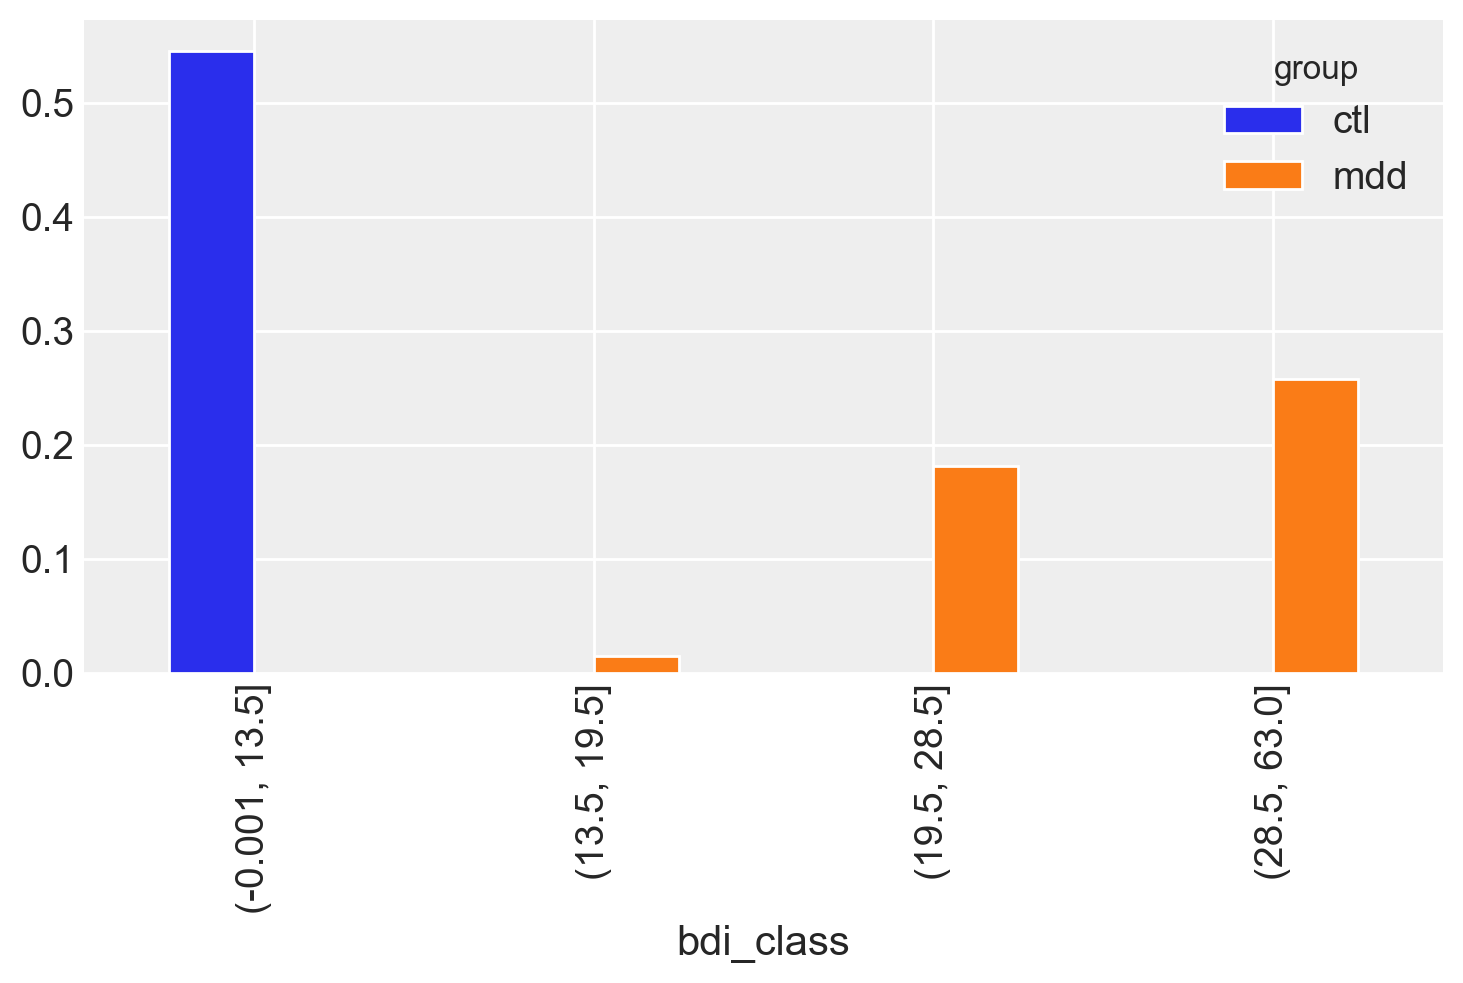

In [15]:
bdi_group_rel_freq.plot.bar();

## Istogramma

Un istogramma rappresenta graficamente una distribuzione di frequenze. Un istogramma mostra sulle ascisse i limiti delle classi $\Delta_i$ e sulle ordinate la densità della frequenza relativa della variabile $X$ nella classe $\Delta_i$. La densità della frequenza relativa è misurata dalla funzione costante a tratti $\varphi_n(x)= \frac{f_i}{b_i-a_i}$, dove $f_i$ è la frequenza relativa della classe $\Delta_i$ e $b_i - a_i$ rappresenta l'ampiezza della classe. In questo modo, l'area del rettangolo associato alla classe $\Delta_i$ sull'istogramma sarà proporzionale alla frequenza relativa $f_i$. È importante notare che l'area totale dell'istogramma delle frequenze relative è uguale a 1.0, poiché rappresenta la somma delle aree dei singoli rettangoli.

Per fare un esempio, costruiamo un istogramma per i valori BDI-II di @zetsche_2019future. Con i quattro intervalli individuati dai cut-off del BDI-II creo una prima versione dell'istogramma -- si notino le frequenze assolute sull'asse delle ordinate.

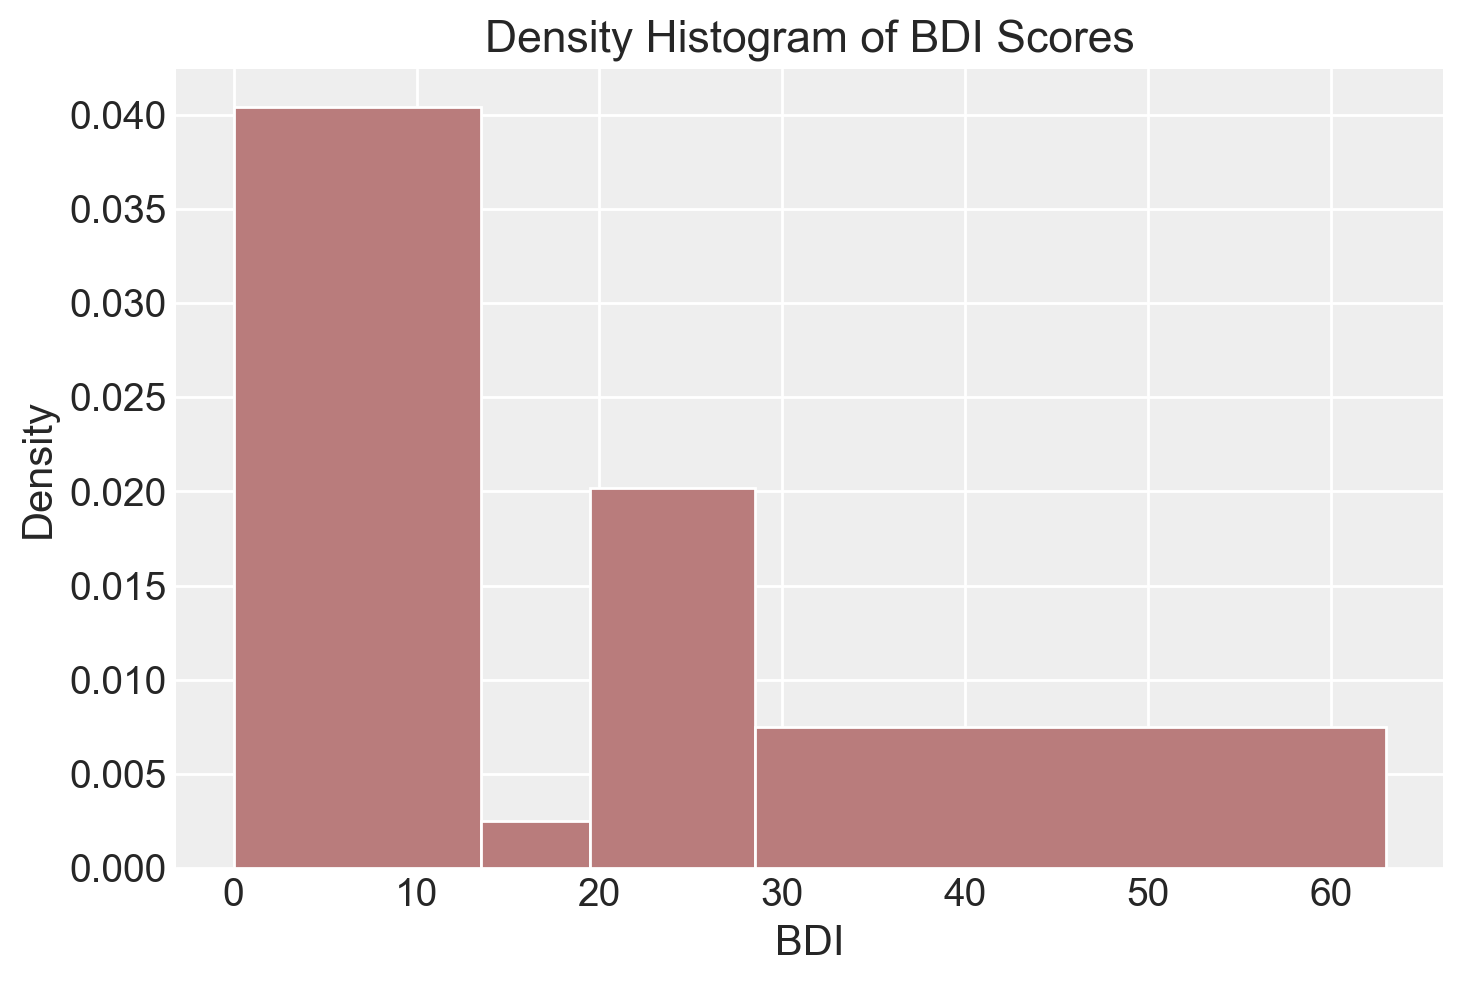

In [16]:
color_fill = "#b97c7c"
plt.hist(df["bdi"], bins=[0, 13.5, 19.5, 28.5, 63], density=True, color=color_fill)
plt.xlabel("BDI")
plt.ylabel("Density")
plt.title("Density Histogram of BDI Scores")
plt.show()

Anche se nel caso presente è sensato usare ampiezze diverse per gli intervalli delle classi, in generale gli istogrammi si costruiscono utilizzando intervalli riportati sulle ascisse con un'ampiezza uguale. 

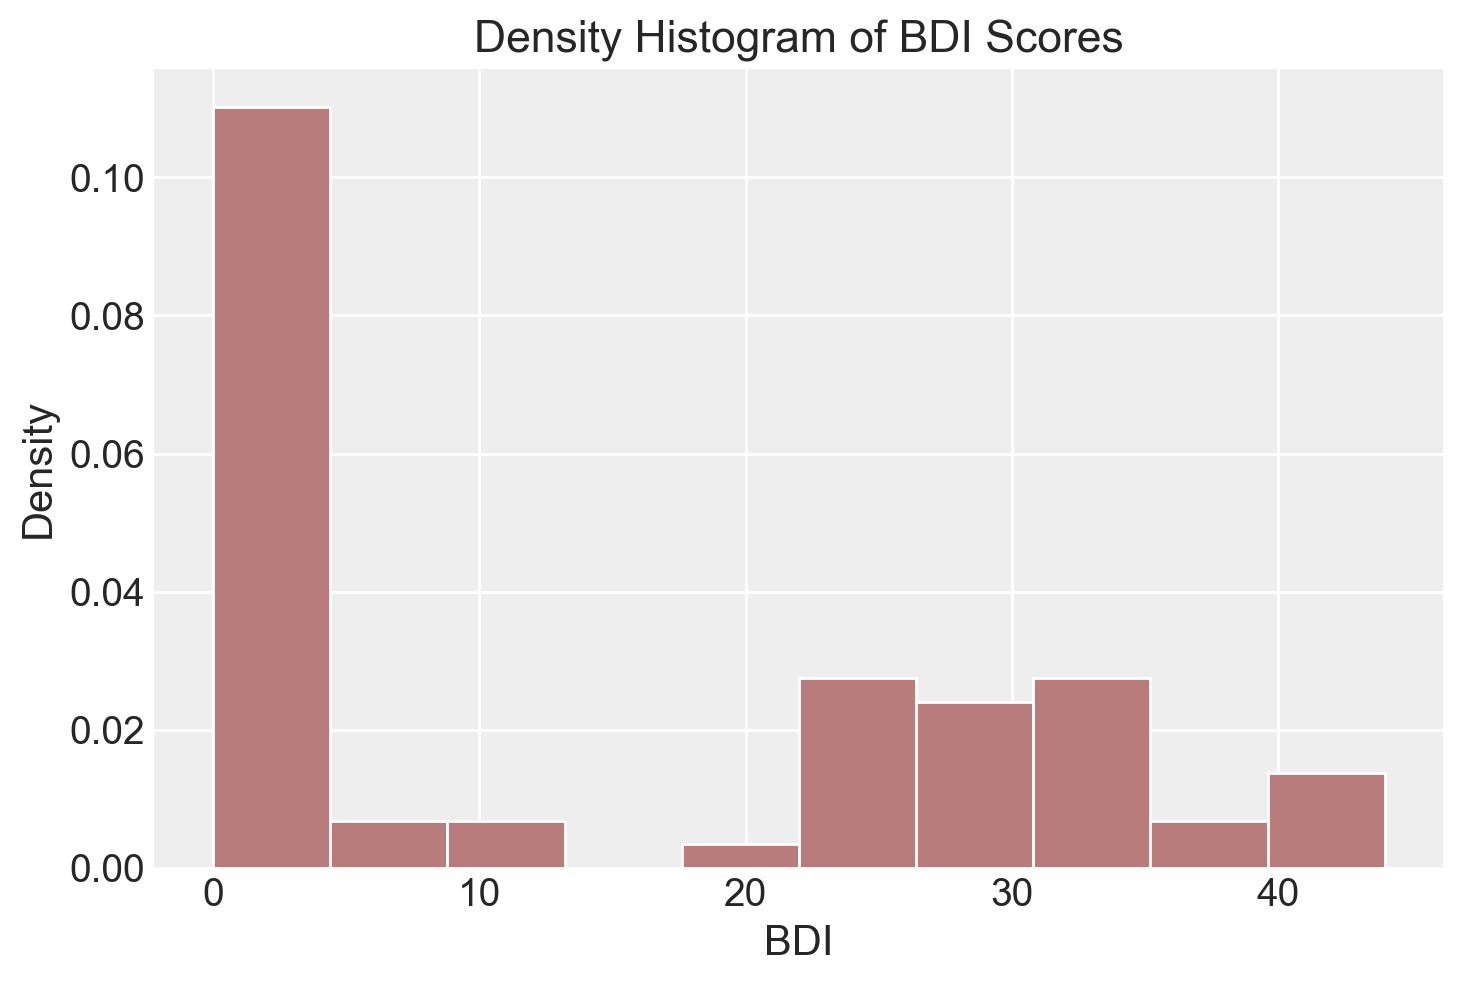

In [17]:
plt.hist(df["bdi"], density=True, color=color_fill)
plt.xlabel("BDI")
plt.ylabel("Density")
plt.title("Density Histogram of BDI Scores")
plt.show()

## Kernel density plot

Confrontando le due figure precedenti, emerge chiaramente una limitazione dell'istogramma: la sua forma dipende dall'arbitrarietà con cui vengono scelti il numero e l'ampiezza delle classi, rendendo difficile interpretare correttamente la distribuzione dei dati.

Per superare questa difficoltà, possiamo utilizzare una tecnica alternativa chiamata *stima della densità kernel* (KDE) -- si veda l'@sec-kde. Mentre l'istogramma utilizza barre per rappresentare i dati, la KDE crea un profilo smussato che fornisce una visione più continua e meno dipendente dall'arbitrarietà delle classi.

Immaginiamo un istogramma con classi di ampiezza molto piccola, tanto da avere una curva continua invece di barre discrete. Questo è ciò che fa la KDE: smussa il profilo dell'istogramma per ottenere una rappresentazione continua dei dati. Invece di utilizzare barre, la KDE posiziona una piccola curva (detta kernel) su ogni osservazione nel dataset. Queste curve possono essere gaussiane (a forma di campana) o di altro tipo. Ogni kernel ha un'altezza e una larghezza determinate da parametri di smussamento (o bandwidth), che controllano quanto deve essere larga e alta la curva. Tutte le curve kernel vengono sommate per creare una singola curva complessiva. Questa curva rappresenta la densità dei dati, mostrando come i dati sono distribuiti lungo il range dei valori. 

La curva risultante dal KDE mostra la proporzione di casi per ciascun intervallo di valori. L'area sotto la curva in un determinato intervallo rappresenta la proporzione di casi della distribuzione che ricadono in quell'intervallo. Per esempio, se un intervallo ha un'area maggiore sotto la curva rispetto ad altri, significa che in quell'intervallo c'è una maggiore concentrazione di dati. 

La curva di densità ottenuta tramite KDE fornisce dunque un'idea chiara di come i dati sono distribuiti senza dipendere dall'arbitrarietà della scelta delle classi dell'istogramma. 

Crediamo un kernel density plot per ciascuno dei due gruppi di valori BDI-II riportati da {cite:t}`zetsche_2019future`.

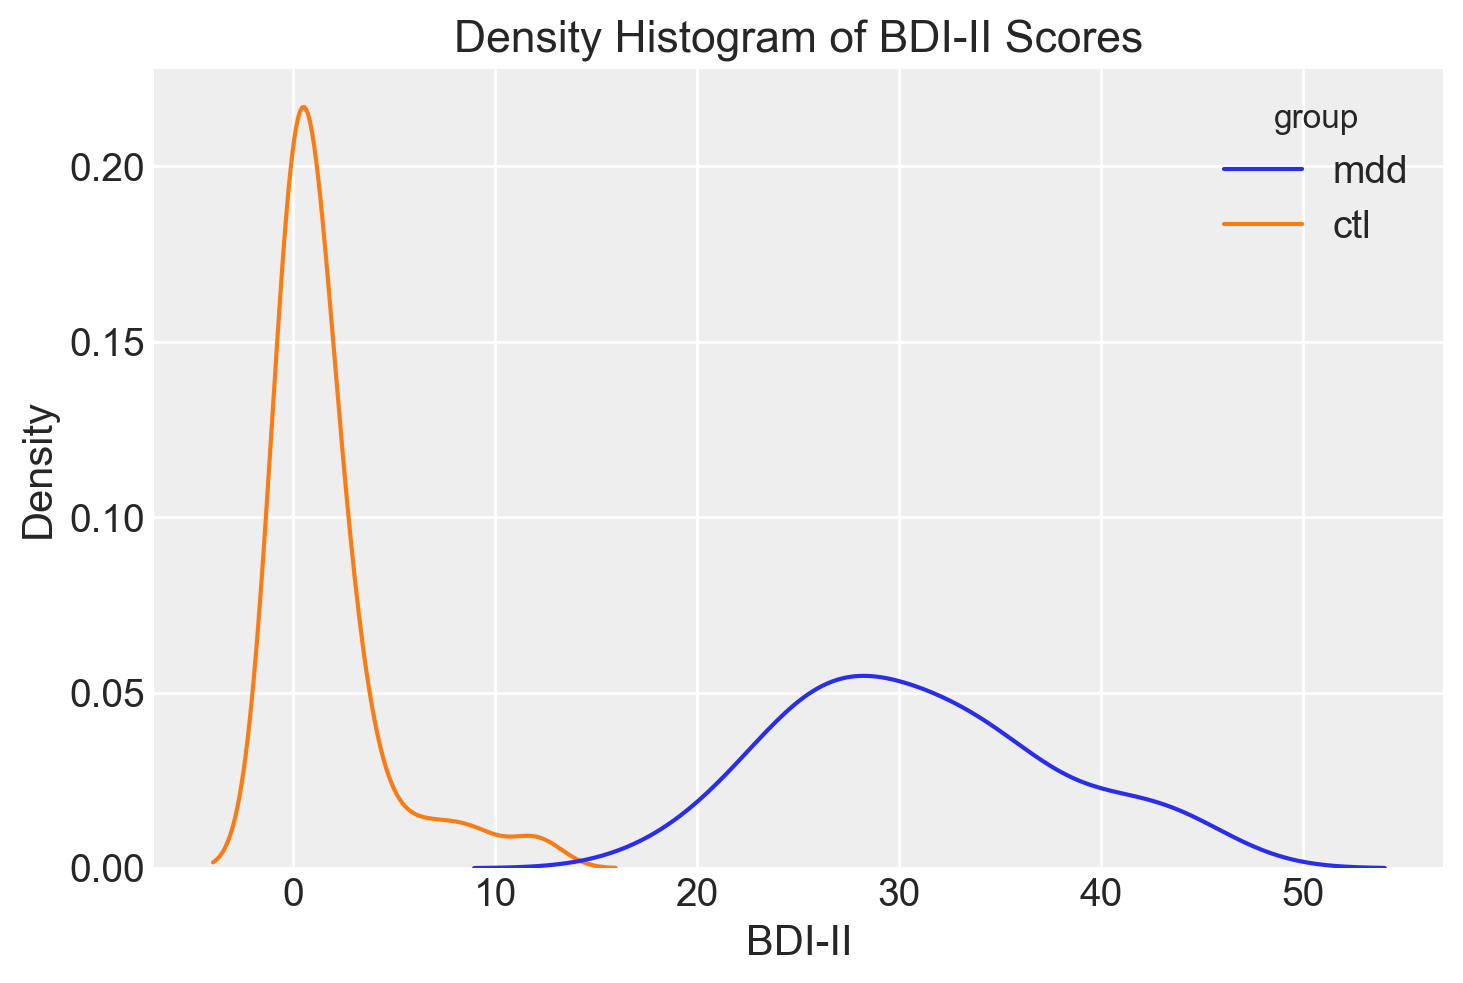

In [18]:
sns.kdeplot(data=df, x="bdi", hue="group", common_norm=False)
plt.xlabel("BDI-II")
plt.ylabel("Density")
plt.title("Density Histogram of BDI-II Scores")
plt.show()

## Consigli per Creare Visualizzazioni di Dati Efficaci 

Ecco alcuni suggerimenti per creare visualizzazioni di dati esplicative, efficaci e di qualità adatta alle presentazioni:

1. **Messaggio chiaro**: Assicurati che il grafico trasmetta un messaggio chiaro e immediato (ad esempio, "Il livello di benessere psicologico dei partecipanti aumenta nel tempo").
2. **Uso del colore**:
   - Utilizza i colori in modo ponderato e con moderazione.
   - Non eccedere nell'uso dei colori solo perché è possibile farlo.
   - Limita l'uso a non più di cinque o sei colori in una singola figura.
   - Verifica che le scelte cromatiche non distorcano le conclusioni della figura.
   - Evita l'uso contemporaneo di rosso e verde nello stesso grafico, poiché queste tonalità sono difficili da distinguere per le persone daltoniche.
3. **Guidare l'attenzione**:
   - Utilizza dimensioni, colori e testo per guidare l'attenzione del pubblico.
   - Evidenzia elementi particolari del grafico per enfatizzare punti chiave.
4. **Gestione del sovraccarico visivo**:
   - Utilizza la trasparenza per ridurre il "sovrapplotting" (che si verifica quando ci sono molti elementi sovrapposti nel grafico, come punti o linee, rendendo difficile individuare i pattern).
   - Questa tecnica è particolarmente utile quando si visualizza una grande quantità di dati.
   - Se il dataset è molto ampio e l'aggiunta di trasparenza non è sufficiente, considera la visualizzazione di un sottocampione dei dati (un campione casuale di punti dati, scelto *senza sostituzione*). Questa tecnica è nota come **sottocampionamento**.
5. **Elementi testuali**:
   - I titoli, le etichette degli assi e il testo delle legende devono essere chiari e facilmente comprensibili.
   - Gli elementi della legenda dovrebbero essere ordinati in modo logico e coerente.

## Forma di una Distribuzione

In statistica, la forma di una distribuzione descrive come i dati sono distribuiti intorno ai valori centrali. Si distingue tra distribuzioni simmetriche e asimmetriche, e tra distribuzioni unimodali e multimodali. Un'illustrazione grafica è fornita nella figura seguente. Nel pannello 1, la distribuzione è unimodale con asimmetria negativa; nel pannello 2, la distribuzione è unimodale con asimmetria positiva; nel pannello 3, la distribuzione è simmetrica e unimodale; nel pannello 4, la distribuzione è bimodale.

![Distribuzioni](../../figures/shape_distribution.png){width="60%"}

Il grafico della densità di kernel (Kernel Density Plot) dei valori BDI-II nel campione di @zetsche_2019future è bimodale. Questo indica che le osservazioni della distribuzione si raggruppano in due cluster distinti: un gruppo di osservazioni tende ad avere valori BDI-II bassi, mentre l'altro gruppo tende ad avere valori BDI-II alti. Questi due cluster di osservazioni corrispondono al gruppo di controllo e al gruppo clinico nel campione di dati esaminato da @zetsche_2019future.

## Indici di posizione

### Quantili

La distribuzione dei valori BDI-II di @zetsche_2019future può essere sintetizzata attraverso l'uso dei quantili, che sono valori caratteristici che suddividono i dati in parti ugualmente numerose. I quartili sono tre quantili specifici: il primo quartile, $q_1$, divide i dati in due parti, lasciando a sinistra il 25% del campione; il secondo quartile, $q_2$, corrisponde alla mediana e divide i dati in due parti uguali; il terzo quartile lascia a sinistra il 75% del campione.

Inoltre, ci sono altri indici di posizione chiamati decili e percentili che suddividono i dati in parti di dimensioni uguali a 10% e 1%, rispettivamente.

Per calcolare i quantili, i dati vengono prima ordinati in modo crescente e poi viene determinato il valore di $np$, dove $n$ è la dimensione del campione e $p$ è l'ordine del quantile. Se $np$ non è un intero, il valore del quantile corrisponde al valore del dato che si trova alla posizione successiva alla parte intera di $np$. Se $np$ è un intero, il valore del quantile corrisponde alla media dei dati nelle posizioni $k$ e $k+1$, dove $k$ è la parte intera di $np$.

Gli indici di posizione possono essere utilizzati per creare un box-plot, una rappresentazione grafica della distribuzione dei dati che è molto popolare e può essere utilizzata in alternativa ad un istogramma.

Ad esempio, per calcolare la mediana della distribuzione dei nove soggetti con un unico episodio di depressione maggiore del campione clinico di @zetsche_2019future, si determina il valore di $np = 9 \cdot 0.5 = 4.5$, che non è un intero. Pertanto, il valore del secondo quartile è pari al valore del dato che si trova alla posizione successiva alla parte intera di $np$, ovvero $q_2 = x_{4 + 1} = 27$. Per calcolare il quantile di ordine $2/3$, si determina il valore di $np = 9 \cdot 2/3 = 6$, che è un intero. Quindi, il valore del quantile corrisponde alla media dei dati nelle posizioni $6$ e $7$, ovvero $q_{\frac{2}{3}} = \frac{1}{2} (x_{6} + x_{7}) = \frac{1}{2} (33 + 33) = 33$.

Usiamo `numpy` per trovare la soluzione dell'esercizio precedente.

In [19]:
x = [19, 26, 27, 28, 28, 33, 33, 41, 43]
np.quantile(x, 2 / 3)

33.0

## Mostrare i dati

### Diagramma a scatola

Il box plot è uno strumento grafico che visualizza la dispersione di una distribuzione. Per creare un box plot, si disegna un rettangolo (la "scatola") di altezza arbitraria, basato sulla distanza interquartile (IQR), che corrisponde alla differenza tra il terzo quartile ($q_{0.75}$) e il primo quartile ($q_{0.25}$). La mediana ($q_{0.5}$) è rappresentata da una linea all'interno del rettangolo.

Ai lati della scatola, vengono tracciati due segmenti di retta, detti "baffi", che rappresentano i valori adiacenti inferiore e superiore. Il valore adiacente inferiore è il valore più basso tra le osservazioni che è maggiore o uguale al primo quartile meno 1.5 volte la distanza interquartile. Il valore adiacente superiore è il valore più alto tra le osservazioni che è minore o uguale al terzo quartile più 1.5 volte la distanza interquartile.

Se ci sono dei valori che cadono al di fuori dei valori adiacenti, vengono chiamati "valori anomali" e sono rappresentati individualmente nel box plot per evidenziare la loro presenza e posizione. In questo modo, il box plot fornisce una rappresentazione visiva della distribuzione dei dati, permettendo di individuare facilmente eventuali valori anomali e di comprendere la dispersione dei dati.

![](../../figures/boxplot.png){width="80%"}

Utilizziamo un box-plot per rappresentare graficamente la distribuzione dei punteggi BDI-II nel gruppo dei pazienti e nel gruppo di controllo.

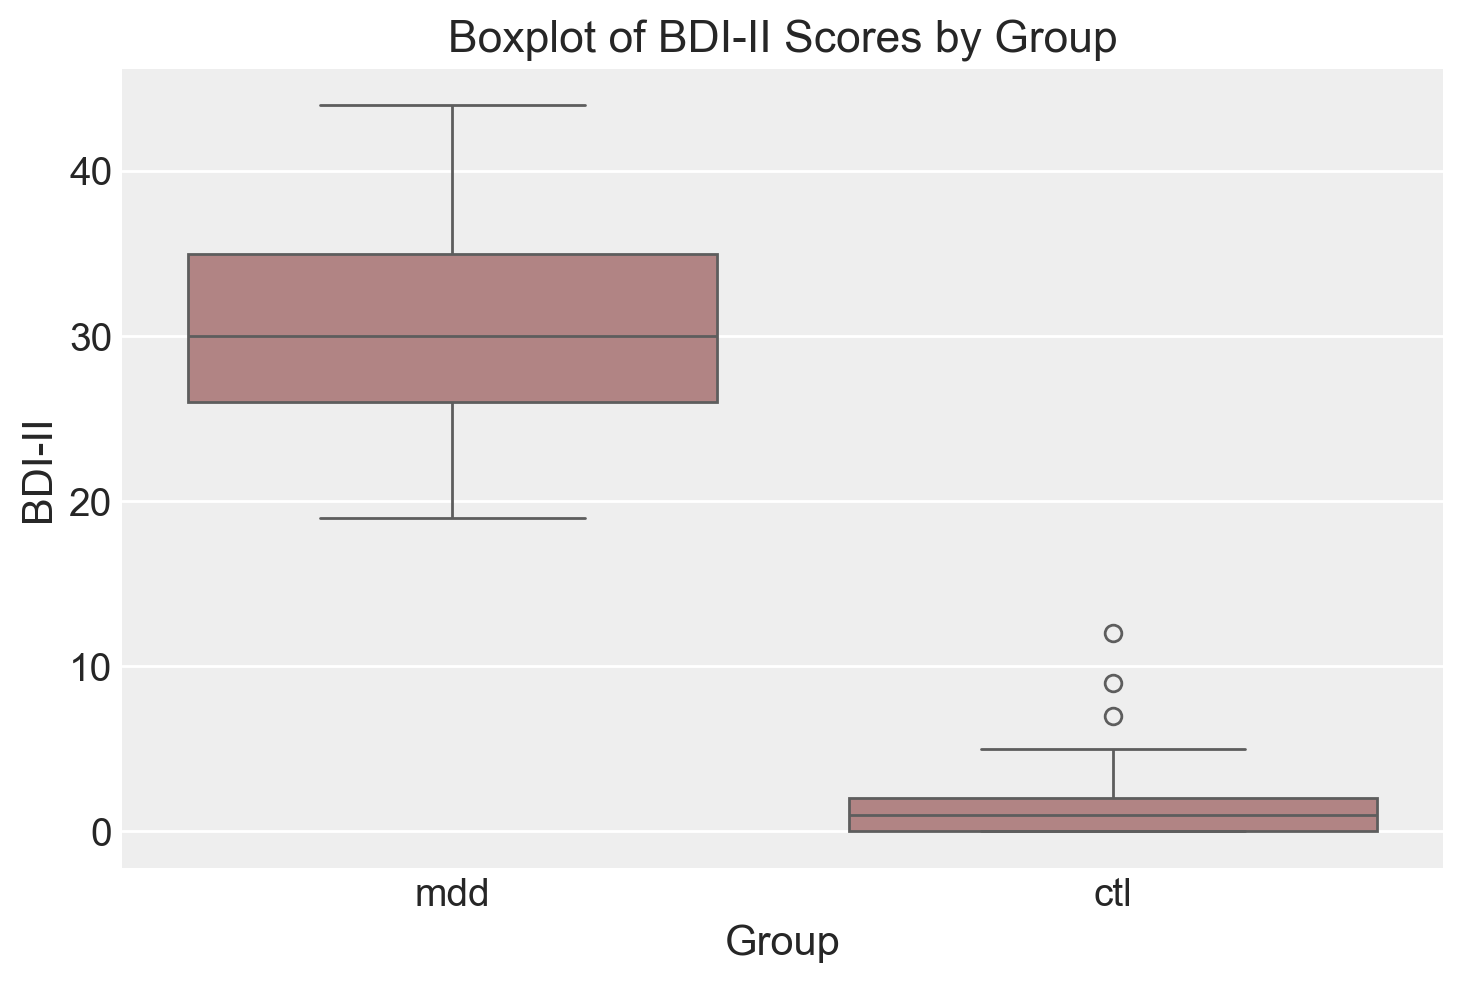

In [20]:
sns.boxplot(x="group", y="bdi", data=df, color=color_fill)
plt.xlabel("Group")
plt.ylabel("BDI-II")
plt.title("Boxplot of BDI-II Scores by Group")
plt.show()

Un risultato migliore si ottiene utilizzando un grafico a violino (*violin plot*) e includendo anche i dati grezzi.

### Grafico a Violino

I grafici a violino combinano le caratteristiche dei box plot e dei grafici di densità di kernel (KDE plot) per offrire una rappresentazione più dettagliata dei dati. A questi grafici vengono sovrapposti i dati grezzi, fornendo una visione completa della distribuzione e delle caratteristiche dei dati.

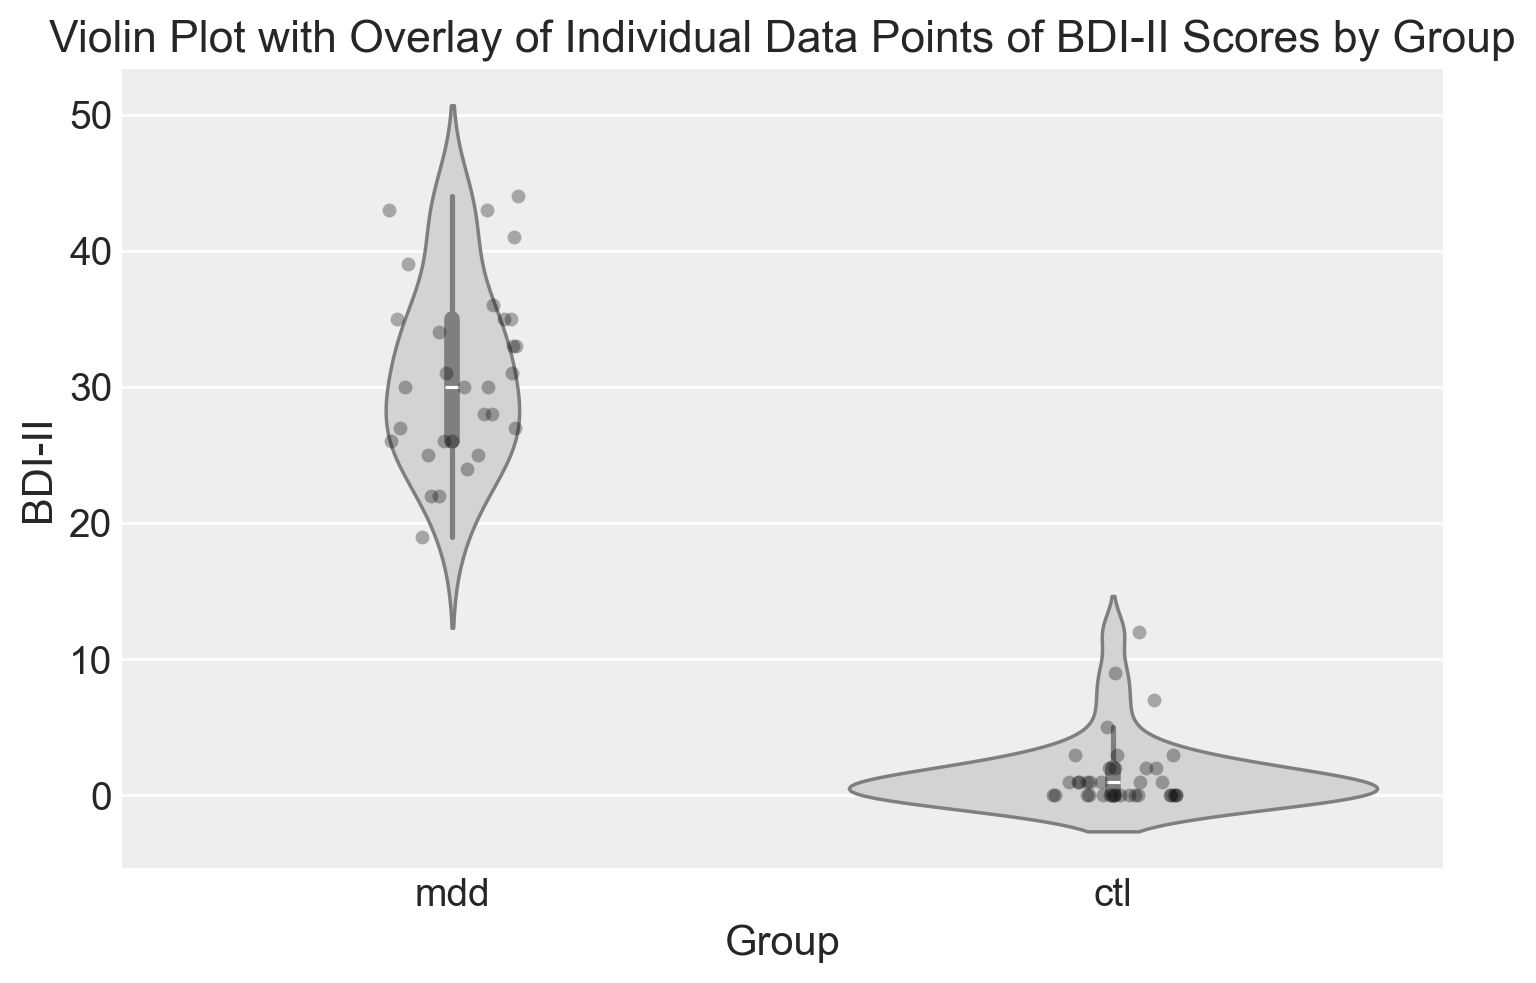

In [21]:
sns.violinplot(x="group", y="bdi", data=df, color="lightgray")
sns.stripplot(x="group", y="bdi", data=df, color="black", size=5, jitter=True, alpha=0.3)
plt.ylabel("BDI-II")
plt.xlabel("Group")
plt.title("Violin Plot with Overlay of Individual Data Points of BDI-II Scores by Group")
plt.show()

## Commenti e considerazioni finali 

Abbiamo esplorato diverse tecniche per sintetizzare e visualizzare i dati, includendo distribuzioni di frequenze, istogrammi e grafici di densità. Questi strumenti sono essenziali per comprendere meglio i dati e presentare risultati in modo chiaro e informativo.

## Informazioni sull'Ambiente di Sviluppo

In [1]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Fri Aug 02 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

Watermark: 2.4.3

